# Titanic Data

I am going to look at the Titanic data as part of this exercise. The dataset comprises of demographic data of the passengers data, fares paid, and whether they survived the incident. Considering the available information, I would like to focus on understanding the following question:
What all factors contributed towards increasing the probability of survival among the Titanic's passengers?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

I start by importing the necessary libraries for the analysis.

# Data Wrangling

In [15]:
titanic_data = pd.read_csv('titanic_data.csv')
titanic_data_orig = titanic_data.copy()
print titanic_data_orig.loc[1:3][['Pclass','Age']]

   Pclass   Age
1       1  38.0
2       3  26.0
3       1  35.0


I import the datset into a dataframe using the read.csv function in the pandas library.

I wanted to check if any of the columns in my dataset contains NULLs as it would otherwise distort my aggregate values.

In [693]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

I found that Age, Cabin, and Embarked contained NULL. The column "Cabin" contained 687 NULLs. The column "Cabin" is a nominal variable used to identify the cabin numbers of the passengers and therefore it is not possible to fill in a logical way. As for "Age", there were 177 missing values. I used the mean value of "Age" to replace the missing values. In the case of "Embarked", there were two missing values which I replaced with the most frequent value (Southampton) as this is a categorical variable.

In [689]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(),inplace=True)

In [690]:
titanic_data['Embarked'].fillna(titanic_data["Embarked"].value_counts().idxmax(),inplace=True)
titanic_data.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
dtype: bool

Finally, I checked if there were any other columns that had missing values except for "Cabin" and there were not.

# Data Exploration & Visualization

I started off by first looking how many survivors and non-survivors we have in our data set.

In [649]:
titanic_data.groupby('Survived').count()['PassengerId']

Survived
0    549
1    342
Name: PassengerId, dtype: int64

In the next step, I used common sense to determine what cross-section might provide useful insight of the data. Typically, women and children are favored during rescue operations. I also know (from the movie) that first class passengers were favored while assigning seats in the lifeboats. So I started looking at these cross-sections.

In [650]:
titanic_data.groupby('Survived').describe()[['Age']]

Age
Survived                  
0        count  549.000000
         mean    30.415100
         std     12.457370
         min      1.000000
         25%     23.000000
         50%     29.699118
         75%     35.000000
         max     74.000000
1        count  342.000000
         mean    28.549778
         std     13.772498
         min      0.420000
         25%     21.000000
         50%     29.699118
         75%     35.000000
         max     80.000000

With "Age", I see that the mean age for Survivors were lower than the Non-Survivors. This could be a result of favoring children during the rescue operation of Titanic. The "median" value although same for both groups, it was artifically synthesized during the data cleansing process - therefore holds less value for the purpose of this analysis.

In [651]:
pd.crosstab(titanic_data['Survived'], titanic_data['Sex']).apply(lambda r: r/r.sum(), axis=0)

Sex,female,male
Survived,,
0,0.257962,0.811092
1,0.742038,0.188908


For the variable "Sex", I noticed that female passengers had a higher survival rate than male passengers.

In [652]:
pd.crosstab(titanic_data['Survived'], titanic_data['Pclass']).apply(lambda r: r/r.sum(), axis=0)

Pclass,1,2,3
Survived,,,
0,0.37037,0.527174,0.757637
1,0.62963,0.472826,0.242363


I noticed that the survival rate for passengers travelling in the 1st Class was significantly higher with regards to those traveling in the 3rd Class and 2nd class passengers were in between the two. This observation also agreed with my hypothesis that I had before starting the analysis (based on what I read and saw in the movie).

In [653]:
pd.crosstab(titanic_data['Survived'], titanic_data['Embarked']).apply(lambda r: r/r.sum(), axis=0)

Embarked,C,Q,S
Survived,,,
0,0.446429,0.61039,0.660991
1,0.553571,0.38961,0.339009


Another variable that I looked at was the Emabrking Port. I noticed that the survival rate for people who embarked on Titanic at Cherbourg (C) was relatively higher in comparison to those who embarked at Queenstown (Q) or Southampton (S).

In [654]:
titanic_data.groupby('Survived').mean()[['SibSp','Parch','Fare']]

,SibSp,Parch,Fare
Survived,,,
0,0.553734,0.329690,22.117887
1,0.473684,0.464912,48.395408


I looked at all the cross-section of the continuous variables for both survivors and non-survivors. As expected, we see signifcantly different mean fares paid by the two groups. However the other two variables - "Parch" (# of traveling parents/children) and "SibSp" (# of traveling siblings/spouse) did not exhibit such marked differences between the two groups.

In [694]:
#titanic_data["Survived"] = titanic_data["Survived"].astype("category",ordered=False)
titanic_data["Sex"] = titanic_data["Sex"].astype("category",ordered=False)
titanic_data["Pclass"] = titanic_data["Pclass"].astype("category",ordered=False)
titanic_data["Embarked"] = titanic_data["Embarked"].astype("category",ordered=False)

The purpose of this step was to convert the categorical variables from strings or numbers to categories.

In [656]:
titanic_data["Sex_Numerical"] = (titanic_data["Sex"] == 'female').astype("int")

The categorical variable "Sex" was coded as "male" and "female" which would have made it impossible to plot in a histogram. So I recoded the "Sex" variable as "Sex_Numerical" where 1 represents "female" and 0 "male".

In [657]:
titanic_data["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [695]:
def assign_fare_cat(fare):
    fare_cat = None
    if fare < 7.91:
        fare_cat = 1
    elif fare > 7.91 and fare < 14.45:
        fare_cat = 2
    elif fare > 14.45 and fare < 31:
        fare_cat = 3
    else:
        fare_cat = 4
    return fare_cat

titanic_data["Fare_Cat"] = titanic_data["Fare"].apply(assign_fare_cat)

I wanted to plot the cross-section of "Fare" vs "Survived". "Fare" is a continuous variable and therefore histograms plotted using "Fare" was getting very dense towards the lower values making it hard to notice any artifacts. The highest value was 512 which made the bin sizes very big for any reasonable value for "Number of bins". So I discretized this variable as well based on the quartiles for "Fare" and renamed it as "Fare_Cat".

In [696]:
def assign_embark_num(embark):
    embark_num = None
    if embark == "C":
        embark_num = 1
    elif embark == "Q":
        embark_num = 2
    else:
        embark_num = 3
    return embark_num

titanic_data["Embark_Num"] = titanic_data["Embarked"].apply(assign_embark_num)

I recoded the "Embarked" variable to a numerical format for the same reason as illustrated above for "Sex" (to plot in a histogram).

# Data Visualization

In [660]:
def get_survival_rate_mod(varName, varValue):
    return (len(titanic_data[(titanic_data[varName]==varValue) & (titanic_data["Survived"]==1)]['Survived'])\
            /float(len(titanic_data[titanic_data[varName]==varValue]['Survived'])),\
           len(titanic_data[(titanic_data[varName]==varValue) & (titanic_data["Survived"]==0)]['Survived'])\
            /float(len(titanic_data[titanic_data[varName]==varValue]['Survived'])))

([<matplotlib.axis.XTick at 0x13cf99cd0>,
 <a list of 2 Text xticklabel objects>)

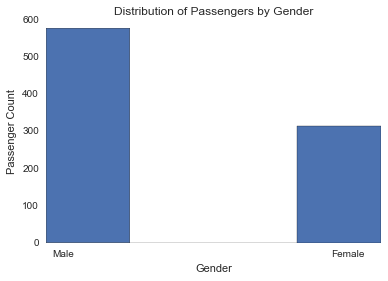

In [661]:
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'

plt.hist(titanic_data["Sex_Numerical"], bins=4)
plt.title("Distribution of Passengers by Gender")
plt.xlabel("Gender")
plt.ylabel("Passenger Count")
xticks_location = (0.05,0.9)
plt.xticks(xticks_location, ('Male', 'Female'))

###### Figure 1: Distribution of male and female passengers

([<matplotlib.axis.XTick at 0x13a923f50>,
 <a list of 2 Text xticklabel objects>)

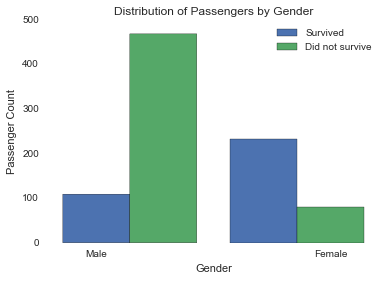

In [662]:
plt.hist([titanic_data[titanic_data["Survived"]==1]['Sex_Numerical'],titanic_data[titanic_data["Survived"]==0]\
          ['Sex_Numerical']],histtype='bar',bins=2)
#plt.hist(titanic_data[titanic_data["Survived"]==0]['Pclass'],histtype='bar')
plt.title("Distribution of Passengers by Gender")
plt.legend(('Survived','Did not survive'))
plt.xlabel("Gender")
plt.ylabel("Passenger Count")
xticks_location = (0.15,0.85)
plt.xticks(xticks_location, ('Male', 'Female'))

###### Figure 2: Distribution of survivors b/w men and women

([<matplotlib.axis.XTick at 0x13d2b10d0>,
 <a list of 2 Text xticklabel objects>)

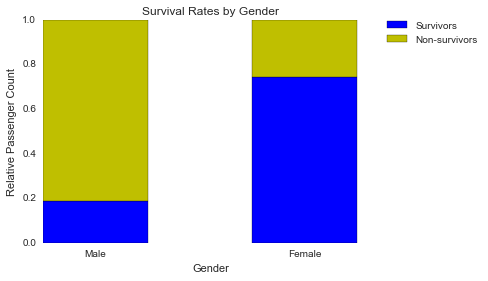

In [663]:
survival_rates_by_female = get_survival_rate_mod('Sex','female')
survival_rates_by_male = get_survival_rate_mod('Sex','male')

survival_rates_by_gender = (survival_rates_by_male[0],survival_rates_by_female[0])
non_survival_rates_by_gender = (survival_rates_by_male[1],survival_rates_by_female[1])

p1 = plt.bar(range(1,3), survival_rates_by_gender, 0.5, color='b')
p2 = plt.bar(range(1,3), non_survival_rates_by_gender, 0.5, color='y', bottom=survival_rates_by_gender)
xticks_location = (1.25,2.25)

plt.title("Survival Rates by Gender")
plt.legend((p1[0], p2[0]), ('Survivors', 'Non-survivors'), loc=3, bbox_to_anchor=(1, 0.85))
plt.xlabel("Gender")
plt.ylabel("Relative Passenger Count")
plt.xticks(xticks_location, ('Male', 'Female'))

###### Figure 3: Relative proportion of survivors b/w male and female

Figures 1 through 3 show the number of male and female passengers in our dataset, the number of survivors among men and women, and finally the relative survival rate between men and women. It is clear from these figures that the survival rate for women was relatively higher than among men.

([<matplotlib.axis.XTick at 0x13cfeb950>,
 <a list of 3 Text xticklabel objects>)

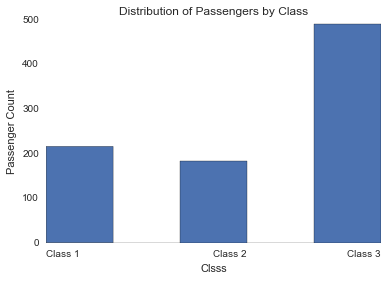

In [664]:
plt.hist(titanic_data['Pclass'], bins=5)
plt.title("Distribution of Passengers by Class")
plt.xlabel("Clsss")
plt.ylabel("Passenger Count")
xticks_location = (1.1,2.1,2.9)
plt.xticks(xticks_location, ('Class 1', 'Class 2', 'Class 3'))

###### Figure 4: Distribution of class 1, class 2, and class 3 passengers

([<matplotlib.axis.XTick at 0x13cf84a50>,
 <a list of 3 Text xticklabel objects>)

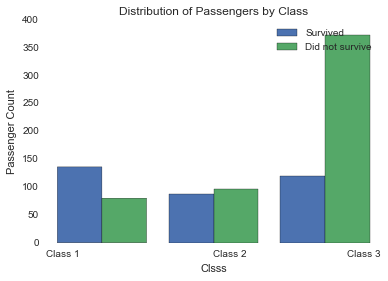

In [665]:
plt.hist([titanic_data[titanic_data["Survived"]==1]['Pclass'],titanic_data[titanic_data["Survived"]==0]\
          ['Pclass']],histtype='bar',bins=3)
#plt.hist(titanic_data[titanic_data["Survived"]==0]['Pclass'],histtype='bar')
plt.title("Distribution of Passengers by Class")
plt.legend(('Survived','Did not survive'))
plt.xlabel("Clsss")
plt.ylabel("Passenger Count")
xticks_location = (1.1,2.1,2.9)
plt.xticks(xticks_location, ('Class 1', 'Class 2', 'Class 3'))

###### Figure 5: Distribution of survivors b/w passenger classes

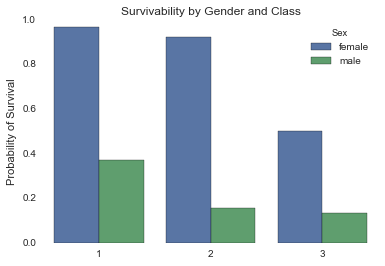

In [671]:
t = titanic_data.groupby(['Pclass', 'Sex'])['Survived'].mean().reset_index()
p = sns.barplot(data =t, x = 'Pclass', y = 'Survived', hue = 'Sex')
p.set(title = 'Survivability by Gender and Class', xlabel = '', ylabel = 'Probability of Survival')

###### Figure 6: Probability of Survival by Gender and Passenger Class 

([<matplotlib.axis.XTick at 0x13d6b9810>,
 <a list of 3 Text xticklabel objects>)

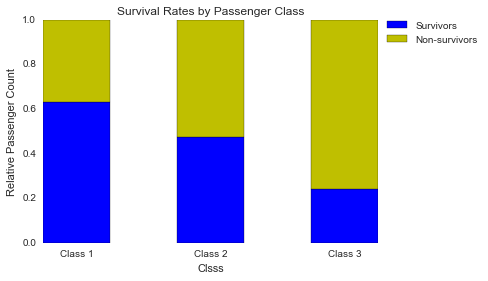

In [673]:
survival_rates_by_class1 = get_survival_rate_mod('Pclass',1)
survival_rates_by_class2 = get_survival_rate_mod('Pclass',2)
survival_rates_by_class3 = get_survival_rate_mod('Pclass',3)

survival_rates_by_class = (survival_rates_by_class1[0],survival_rates_by_class2[0],survival_rates_by_class3[0])
non_survival_rates_by_class = (survival_rates_by_class1[1],survival_rates_by_class2[1],survival_rates_by_class3[1])
xticks_location = (1.25,2.25,3.25)

p1 = plt.bar(range(1,4), survival_rates_by_class, 0.5, color='b')
p2 = plt.bar(range(1,4), non_survival_rates_by_class, 0.5, color='y', bottom=survival_rates_by_class)

plt.title("Survival Rates by Passenger Class")
plt.legend((p1[0], p2[0]), ('Survivors', 'Non-survivors'), loc=3, bbox_to_anchor=(1, 0.85))
plt.xlabel("Clsss")
plt.ylabel("Relative Passenger Count")
plt.xticks(xticks_location, ('Class 1', 'Class 2', 'Class 3'))

###### Figure 7: Relative proportion of survivors b/w passenger classes

Figures 4 through 7 show the number of passengers traveling in classes 1, 2, and 3 in our dataset, the number of survivors in each of three separate classes, the relative survival rate between these classes, and finally the survival rates between men and women by passenger class. There is a noticeable trend in the data - the chances of survival improve from class 3 to 2 and and 2 to 1. It was also interesting to note that the survival rate among women in passenger classes 1 and 2 were almost 100% while that for women in class 3 it is about half of that.

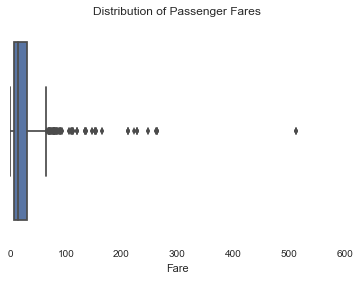

In [700]:
sns.boxplot(data = titanic_data.dropna(subset = ['Fare']),x = 'Fare')
plt.title("Distribution of Passenger Fares")

###### Figure 8: Distribution of Passenger Fares

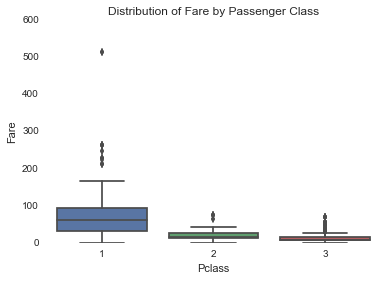

In [672]:
sns.boxplot(data = titanic_data.dropna(subset = ['Fare']), x = 'Pclass', y = 'Fare')

plt.title("Distribution of Fare by Passenger Class")

###### Figure 9: Distribution of fare by passenger classes
(It is evenly distributed because the splits were created based on the quartile boundaries)

([<matplotlib.axis.XTick at 0x13d563bd0>,
 <a list of 4 Text xticklabel objects>)

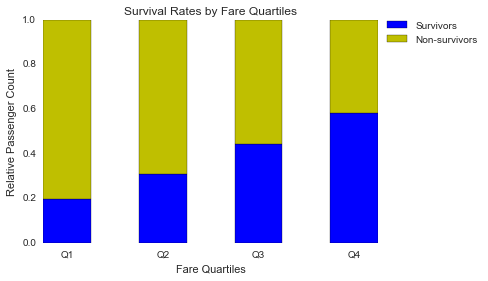

In [676]:
survival_rates_by_fare_cat1 = get_survival_rate_mod('Fare_Cat',1)
survival_rates_by_fare_cat2 = get_survival_rate_mod('Fare_Cat',2)
survival_rates_by_fare_cat3 = get_survival_rate_mod('Fare_Cat',3)
survival_rates_by_fare_cat4 = get_survival_rate_mod('Fare_Cat',4)

survival_rates_by_fare_quart = (survival_rates_by_fare_cat1[0],survival_rates_by_fare_cat2[0],\
                                survival_rates_by_fare_cat3[0],survival_rates_by_fare_cat4[0])
non_survival_rates_by_fare_quart = (survival_rates_by_fare_cat1[1],survival_rates_by_fare_cat2[1],
                                    survival_rates_by_fare_cat3[1],survival_rates_by_fare_cat4[1])

p1 = plt.bar(range(1,5), survival_rates_by_fare_quart, 0.5, color='b')
p2 = plt.bar(range(1,5), non_survival_rates_by_fare_quart, 0.5, color='y', bottom=survival_rates_by_fare_quart)

plt.title("Survival Rates by Fare Quartiles")
plt.legend((p1[0], p2[0]), ('Survivors', 'Non-survivors'), loc=3, bbox_to_anchor=(1, 0.85))
plt.xlabel("Fare Quartiles")
plt.ylabel("Relative Passenger Count")
xticks_location = (1.25,2.25,3.25,4.25)
plt.xticks(xticks_location, ('Q1', 'Q2', 'Q3', 'Q4'))

###### Figure 10: Relative proportion of survivors b/w fare quartiles

Figures 8 through 10 show the distribution of passenger fares, its distribution among passengers traveling in different classes, and the relative survival rates in each fare quartile. It is quite evident from Figure 9 that the average fare paid by passengers traveling in Class 1 was higher than Class 2 which was higher than Class 3. The figure also indicates that there was at least one outlier that was above and beyond any other record in the dataset. The trend for the survival rate is linear and increases monotonically as we go from lowest to the highest fare quartile. This is not surprising as passengers traveling in higher classes (denoted by lower number) tend to pay higher fares. Previous figures have already shown the survival rate in Classes 1 and 2 to be substantially higher than Class 3. Therefore, these two variables are highly correlated and the survival trends mimic each other.

([<matplotlib.axis.XTick at 0x13d56b390>,
 <a list of 3 Text xticklabel objects>)

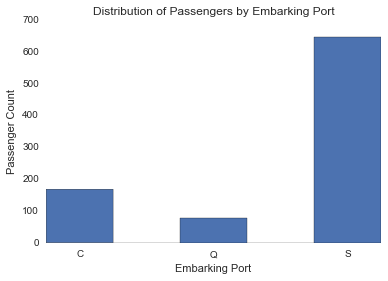

In [678]:
plt.hist(titanic_data["Embark_Num"], bins=5)

plt.title("Distribution of Passengers by Embarking Port")
plt.xlabel("Embarking Port")
plt.ylabel("Passenger Count")
xticks_location = (1.2,2.0,2.8)
plt.xticks(xticks_location, ('C', 'Q', 'S'))

###### Figure 11: Distribution of passengers by embarking port

([<matplotlib.axis.XTick at 0x13fe8ca10>,
 <a list of 3 Text xticklabel objects>)

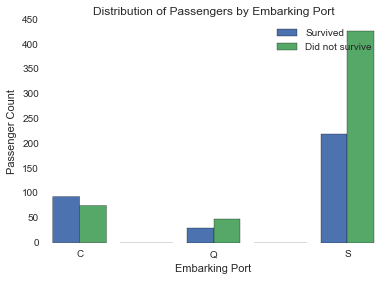

In [697]:
plt.hist([titanic_data[titanic_data["Survived"]==1]['Embark_Num'],titanic_data[titanic_data["Survived"]==0]\
          ['Embark_Num']],histtype='bar',bins=5)
#plt.hist(titanic_data[titanic_data["Survived"]==0]['Pclass'],histtype='bar')
plt.title("Distribution of Passengers by Embarking Port")
plt.legend(('Survived','Did not survive'))
plt.xlabel("Embarking Port")
plt.ylabel("Passenger Count")
xticks_location = (1.2,2.0,2.8)
plt.xticks(xticks_location, ('C', 'Q', 'S'))

###### Figure 12: Distribution of survivors b/w embarking ports

([<matplotlib.axis.XTick at 0x13dfcb150>,
 <a list of 3 Text xticklabel objects>)

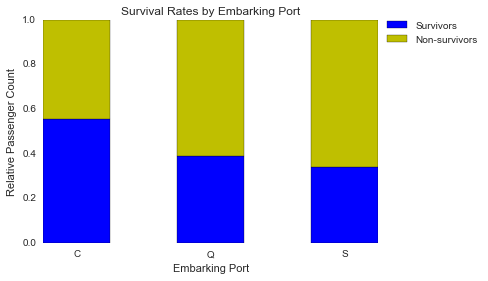

In [680]:
survival_rates_by_portC = get_survival_rate_mod('Embarked','C')
survival_rates_by_portQ = get_survival_rate_mod('Embarked','Q')
survival_rates_by_portS = get_survival_rate_mod('Embarked','S')

survival_rates_by_port = (survival_rates_by_portC[0],survival_rates_by_portQ[0],survival_rates_by_portS[0])
non_survival_rates_by_port = (survival_rates_by_portC[1],survival_rates_by_portQ[1],survival_rates_by_portS[1])

p1 = plt.bar(range(1,4), survival_rates_by_port, 0.5, color='b')
p2 = plt.bar(range(1,4), non_survival_rates_by_port, 0.5, color='y', bottom=survival_rates_by_port)

plt.title("Survival Rates by Embarking Port")
plt.legend((p1[0], p2[0]), ('Survivors', 'Non-survivors'), loc=3, bbox_to_anchor=(1, 0.85))
plt.xlabel("Embarking Port")
plt.ylabel("Relative Passenger Count")
xticks_location = (1.25,2.25,3.25)
plt.xticks(xticks_location, ('C', 'Q', 'S'))

###### Figure 13: Relative proportion of survivors b/w embarking ports

Figures 11 through 13 show the number of passengers that embarked at each of the three ports, the number of survivors for each of the ports, and the relative survival rate for these three ports. While the survival rate for passengers boarding from Cherbourg was slightly higher, it was about the same for passengers who boarded from Southampton and Queenstown.

# Optional: Logistic Regression: Model Coefficients & Statistical Significance

The purpose of this exerice is to determine if the variables highlighted in the foregoing discussion actually have a statistically significant effect on the the probability of survival of the passengers. The goal was not to build a robust model but rather objectively quantify the effect of the independent variables in the data set on the response variable. So in this context I used the entire data set for training the model rather than splitting the data into training and test data sets because I was not interested in obtaining out-of-sample accuracies or any other similar metrics.
Considering the problem (two probable outcomes) at hand, a binary choice model is the approach to take. I used a logistic specification for the problem.

In [681]:
y, X = dmatrices('Survived ~ Fare + Age + C(Embarked) + C(Pclass) + SibSp + Parch + C(Sex)', titanic_data, return_type="dataframe")

I start by converting the "Titanic" dataframe into a matrix with a one-dimensional array for the response variable and two-dimensional array for the regressors in the model. As a starting point, I used the categorical variables "Embarked", "Sex", and "Pclass" and the continuous variables "Fare", "Age", "Parch", and "SibSp".

In [577]:
print X.columns

Index([u'Intercept', u'C(Embarked)[T.Q]', u'C(Embarked)[T.S]',
       u'C(Pclass)[T.2]', u'C(Pclass)[T.3]', u'C(Sex)[T.male]', u'Fare',
       u'Age', u'SibSp', u'Parch'],
      dtype='object')


I wanted to check the names of the dummy variables created for each of the categorical variables. It should be noted that the dummy variables measure the additional effect of the particular value of categorical variable with respect to the baseline. In this case, "Cherbourg" was the baseline embarking port, "Female" was the baseline value for the "Sex" variable, and Class 1 was the baseline value for the passenger class. 

In [609]:
y_flat = np.ravel(y['Survived[1]'])

I noticed that convertng the response variable (Survived) into a matrix created a two-dimensional array with the number of rows being same as the number of observation but two separate rows for the outcome, one where the values were coded for Survived = 1 and the other being Survived = 0. I chose to model the "Survived = 1" column implying that the coefficients will predict the probablity of survival opposed to non-survival. 

In [619]:
model = sm.Logit(y_flat, X)
model_summary = model.fit(disp=0)
print('Parameters: ', model_summary.params)

model_significance = model_summary.get_margeff()
print(model_significance.summary())

('Parameters: ', Intercept           4.104468
C(Embarked)[T.Q]   -0.028504
C(Embarked)[T.S]   -0.439785
C(Pclass)[T.2]     -0.931609
C(Pclass)[T.3]     -2.155635
C(Sex)[T.male]     -2.718753
Fare                0.002296
Age                -0.039088
SibSp              -0.323446
Parch              -0.097054
dtype: float64)
        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                      dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
C(Embarked)[T.Q]    -0.0040      0.054     -0.075      0.941        -0.109     0.101
C(Embarked)[T.S]    -0.0617      0.033     -1.845      0.065        -0.127     0.004
C(Pclass)[T.2]      -0.1306      0.041     -3.180      0.001        -0.211    -0.050
C(Pclass)[T.3]      -0.3022      0.038     -7.911      0.000        -0.377    -0.227
C(Sex)[T.male] 

The model summary is shown above. I am going to summarize my findings below.
1. Figures 10 through 12 suggested that the survival rate for passenger who boarded from Cherbourg was slightly higher than the other two locations, the model summary presented above suggest that the difference is not statistically significant.
2. Passenger classes 2 and 3 were both found statistically significant. The negative coefficient indicate that the probability of survival for passengers traveling in those classes is lower than somebody traveling in Class 1 (baseline). The coefficient for passenger class 3 was lower than class 2 which reinforces the trend that was earlier observed: Survival(Class 1) > Survival(Class 2) > Survival(Class 3).
3. The significance of the variable "Fare" suggests that it was not significant. This was also expected as we also included passenger class in our model and these two variables are highly correlated. Therefore, the predictive power for "Fare" is greatly diminshed as it is already accounted through inclusion of passenger class in our model.
4. The effect of "Age" on the probability of survival was also found significant. The negative coefficient suggests that the probability of survival for older people is relatively smaller than younger people which aligns with our expectation as children were priortized in the rescue operation of the Titanic passengers.
5. The dummy variable for male passengers was also statistically significant. Just as I expected, the negative coeeficient suggest that the probability of survival for male passengers was significantly less than females.
6. The effect of "SibSp" on the probability of survival was found significant. The negative sign indicate that passengers travelling with their spouse or siblings are less likely to survive the accident. This could be a result of how passenger were priortized for the rescue operation.
7. Finally, the effect of the variable "Parch" on the probability of survival of Titanic passengers was found to be statistically insignificant.

# Conclusion

As part of this exercise, I looked at the Titanic passenger data. I started by loading the data from the csv file into a dataframe. I noticed that three of the variables - Age, Embarked, and Cabin contained NULL. The missing values for Age was replaced with the average age for the Titanic passenger data set. The missing embarking ports were replaced with the most frequent embarking port (Southampton). The missing values for "Cabin" were left as they were as there was no logical way to replace them. Furthermore, "Cabin" being a nominal variable would have little to no bearing on the survival rate for the Titanic passengers.
In the following section, I looked at some descriptive statistics which included univariate statitics for Survived to determine how many survivors and non-survivors we had in the dataset. This was folllowed by looking at bivariate statisitics to obtain insight of the trend between the explanatory variables and the response variable. To that effect, I looked at the cross-section of Fare, Sex, Embarked, Age, and SibSp. The tabular and graphical data suggested the following trend in the survival rate among the Titanic passengers:
i. Survival(Female) > Survival(Male)
ii. Survival(Class 1) > Survival(Class 2) > Survival(Class 3)
iii. Survival(Higher fare) > Survival(Lower fare)
iv. Survival(Younger passengers) > Survival(Older passengers)
v. Survival(Passengers embarked from Cherbourg) > Survival(Passenger embarked at Southampton or Queenstown)
While this analysis gave a qualitative definition regarding trends in the passenger survival rates, most of it was based on visual examination of the data and point estimates. 
To complement these findings and to obtain more confidence in the trend, I modeled the passenger data using a logistic specification. I modeled the log of odds of survival as a linear response to the regressors in our dataset (Age, Sex, SibSp, Parch, Embarked, Fare, and Pclass). The model summary suggested similar findings as our observations from the visual inspection of the data. The survival probability was higher for passengers traveling in class 1 was higher than that of class 2 and class 2 than that of class 3. Furthermore the probability of survival was higher for female passengers w.r.t. males and younger people w.r.t. older people. Contrary to previous findings, the probability of survival for passengers boarding from Cherbourg was not statitically different from Queenstown or Southampton. Last but not the least, the effect of "Fare" on the chances of survival was found statitically insignificant but this was expected as the passenger class and fare variables were cited as highly correlated and hence the predictive power of "Fare" was diminished.

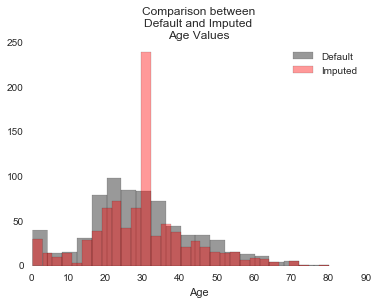

In [692]:
sns.distplot(titanic_data_orig.Age.dropna(), kde = False, label = 'Default', color='black')
sns.distplot(titanic_data_orig.Age.fillna(titanic_data_orig.Age.mean()), kde = False, label = 'Imputed', color = "red")
plt.title('Comparison between\nDefault and Imputed\nAge Values')
plt.legend()

###### Figure 14: Default vs imputed Age Values

With respect to the observations presented above, there is one caveat. I have cited earlier that there were 177 observations that had missing values for "Age" and these were imputed with the mean of "Age" obtained from all other observations. As a result, we see that the bucket containing 30 in Figure 14 is the most frequent age group. Should someone choose to impute these values in a different way or remove the observations altogether, the findings can change and the significance of Age in determining the probability of survival will vary.